In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer


In [3]:
game_reviews = pd.read_csv("all_Steam_Reviews_cleaned_1.csv")
pos_reviews=pd.read_csv("positive_steam_reviews_1.csv")
neg_reviews=pd.read_csv("negative_steam_reviews_1.csv")

In [4]:
pos_reviews

,game,review,recommended,genre,action,strategy,free_to_play,adventure,massively_multiplayer,indie,...,casual,racing,early_access,simulation,unknown_genre,sports,violent,education,utilities,cleaned_review
0,Company of Heroes 3,Here is my actual review. COH3 has the best Qo...,True,"Action, Strategy",True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,actual review good qol franchise stop play fav...
1,Company of Heroes 3,I resisted for quite a while to buy this game ...,True,"Action, Strategy",True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,resist buy game not expect game different fina...
2,Company of Heroes 3,Final Thoughts\nCompany of Heroes 3 is a stunn...,True,"Action, Strategy",True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,final thought company heroe stunning evolution...
3,Company of Heroes 3,game has come a long way since release but can...,True,"Action, Strategy",True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,game come long way release feel like cash grab...
4,Company of Heroes 3,A great RTS that is going to get better with e...,True,"Action, Strategy",True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,great rt go well major update time start play ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34040,Baldur's Gate 3,It's not just a game! It's a whole story that ...,True,"Adventure, RPG, Strategy",False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,game story completely immerse primarily thank ...
34041,Baldur's Gate 3,It's the closest you're going to get to playin...,True,"Adventure, RPG, Strategy",False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,close go play dnd group friend willing sit pla...
34042,Baldur's Gate 3,verry gooood gammeeee. I slept on it for to lo...,True,"Adventure, RPG, Strategy",False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,verry gooood gammeeee sleep long finish ton co...
34043,Baldur's Gate 3,Funny wild magic sorceror Durge run made every...,True,"Adventure, RPG, Strategy",False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,funny wild magic sorceror durge run turn cat t...


In [5]:
#avoid error later
pos_reviews.rename(columns={'game': 'Game'}, inplace=True)
neg_reviews.rename(columns={'game': 'Game'}, inplace=True)
game_reviews.rename(columns={'game': 'Game'}, inplace=True)



In [6]:
# Define TF-IDF vectorizers
vectorizer_pos = TfidfVectorizer(stop_words="english", ngram_range=(1,2), max_features=5000)  # Unigrams & bigrams
vectorizer_neg = TfidfVectorizer(stop_words="english", ngram_range=(1,2), max_features=5000)  # Unigrams & bigrams

# Remove NaN values from the cleaned_review columns
pos_reviews_cleaned = pos_reviews["cleaned_review"].dropna()
neg_reviews_cleaned = neg_reviews["cleaned_review"].dropna()

# Fit and transform the positive reviews
tfidf_matrix_pos = vectorizer_pos.fit_transform(pos_reviews_cleaned)

# Fit and transform the negative reviews
tfidf_matrix_neg = vectorizer_neg.fit_transform(neg_reviews_cleaned)

# Get feature names
terms_pos = vectorizer_pos.get_feature_names_out()
terms_neg = vectorizer_neg.get_feature_names_out()

# Compute the mean TF-IDF scores per term
tfidf_sum_pos = tfidf_matrix_pos.mean(axis=0).A1
tfidf_sum_neg = tfidf_matrix_neg.mean(axis=0).A1

# Create DataFrames with terms and scores
tfidf_df_pos = pd.DataFrame({'term': terms_pos, 'tfidf_score': tfidf_sum_pos})
tfidf_df_neg = pd.DataFrame({'term': terms_neg, 'tfidf_score': tfidf_sum_neg})

# Sort by importance (highest TF-IDF scores)
tfidf_df_pos = tfidf_df_pos.sort_values(by="tfidf_score", ascending=False)
tfidf_df_neg = tfidf_df_neg.sort_values(by="tfidf_score", ascending=False)


In [7]:
# Define function to get top words per game
def get_top_words_per_game(reviews_df, vectorizer, top_n=10):
    top_words_per_game = {}

    for game in reviews_df["Game"].unique():
        # Filter reviews for the specific game
        game_reviews = reviews_df[reviews_df["Game"] == game]["cleaned_review"]

        if game_reviews.empty:
            continue  # Skip if no reviews

        # Apply TF-IDF for the specific game
        tfidf_matrix = vectorizer.fit_transform(game_reviews)
        terms = vectorizer.get_feature_names_out()

        # Compute mean TF-IDF scores for words
        row = tfidf_matrix.mean(axis=0).A1
        sorted_terms = [terms[idx] for idx in row.argsort()[::-1][:top_n]]

        # Store in dictionary
        top_words_per_game[game] = sorted_terms

    return top_words_per_game





In [8]:
# Remove NaN values from the cleaned_review columns
pos_reviews_cleaned = pos_reviews.dropna(subset=['cleaned_review'])
neg_reviews_cleaned = neg_reviews.dropna(subset=['cleaned_review'])

# Compute top words per game for positive & negative reviews
top_words_pos = get_top_words_per_game(pos_reviews_cleaned, vectorizer_pos)
top_words_neg = get_top_words_per_game(neg_reviews_cleaned, vectorizer_neg)

In [9]:
# Ensure both dictionaries have the same keys
games = set(top_words_pos.keys()).union(set(top_words_neg.keys()))

# Create lists for DataFrame
games_list = []
top_pos_words_list = []
top_neg_words_list = []

for game in games:
    games_list.append(game)
    top_pos_words_list.append(top_words_pos.get(game, []))
    top_neg_words_list.append(top_words_neg.get(game, []))

# Convert to DataFrame
df_top_words = pd.DataFrame({
    "Game": games_list,
    "Top_Positive_Words": top_pos_words_list,
    "Top_Negative_Words": top_neg_words_list
})

# Save to CSV
df_top_words.to_csv("game_top_tfidf_words.csv", index=False)


In [10]:
df_top_words

,Game,Top_Positive_Words,Top_Negative_Words
0,Destiny 2,"[game, good, play, great, fun, like, destiny, ...","[game, play, content, player, good, time, new,..."
1,Far Cry® 5,"[game, good, fun, far, play, story, good game,...","[game, ubisoft, play, bad, buy, story, like, b..."
2,Cursed to Golf,"[game, amazing, game amazing, golf, hole, card...","[game, stroke, card, weird, tutorial, golf, fe..."
3,PAYDAY 2,"[game, good, fun, payday, good game, love, pla...","[game, dlc, violence, need, fuck, time, suck, ..."
4,Split Fiction,"[game, play, fun, good, story, amazing, coop, ...","[game, story, world, feel, character, play, wo..."
...,...,...,...
92,Tower Unite,"[fun, game, play, friend, tower, hour, loooooo...","[game, devs, report, road, thing, house, kind ..."
93,DARK SOULS™ III,"[game, good, soul, great, dark, dark soul, goo...","[game, soul, play, dark, dark soul, boss, like..."
94,Dead Cells,"[good, game, fun, play, good game, like, love,...","[game, like, bore, hard, hogass, fun, control,..."
95,Sekiro™: Shadows Die Twice - GOTY Edition,"[game, good, combat, good game, play, fun, bos...","[game, controller, like, work, boss, time, pla..."


As we can see the words have some like "game", "good", "play", "great", "bad" that doesnt really say nothing to us, therefore we have to add them to a stopword list to remove them.

In [11]:
# Custom stopwords to remove
custom_stopwords = {"ve", "re", "want", "try", "new", "work", "need", "thing", "buy", "fix", 
    "hour", "long", "gameplay", "update", "dlc", "player", "pay",
    'time', 'game', 'play', 'good', 'great', 'bad', 'like', 'fun', 
    'best', 'better', 'enjoy', 'recommend', 'yes', "feel", "lot", "come", "way", "nice", "ha", "think",
    "aight", "haha", "gobagool", "goate", "unsuur", "jyjtyjtukutk"
}


def remove_custom_stopwords(text):
    # Tokenize the text using whitespace and remove custom stopwords (ignoring case)
    tokens = text.split()
    filtered_tokens = [token for token in tokens if token.lower() not in custom_stopwords]
    return ' '.join(filtered_tokens)

# Remove NaN values and then apply the custom stopwords removal for positive reviews
pos_reviews_cleaned = pos_reviews.dropna(subset=['cleaned_review'])
pos_reviews_cleaned["cleaned_review"] = pos_reviews_cleaned["cleaned_review"].apply(remove_custom_stopwords)

# Remove NaN values and apply custom stopwords removal for negative reviews
neg_reviews_cleaned = neg_reviews.dropna(subset=['cleaned_review'])
neg_reviews_cleaned["cleaned_review"] = neg_reviews_cleaned["cleaned_review"].apply(remove_custom_stopwords)

# Define TF-IDF vectorizers
vectorizer_pos = TfidfVectorizer(stop_words="english", ngram_range=(1,2), max_features=5000)  # Unigrams & bigrams for positive reviews
vectorizer_neg = TfidfVectorizer(stop_words="english", ngram_range=(1,2), max_features=5000)  # Unigrams & bigrams for negative reviews

# Fit and transform the positive reviews
tfidf_matrix_pos = vectorizer_pos.fit_transform(pos_reviews_cleaned["cleaned_review"])

# Fit and transform the negative reviews
tfidf_matrix_neg = vectorizer_neg.fit_transform(neg_reviews_cleaned["cleaned_review"])

# Get feature names
terms_pos = vectorizer_pos.get_feature_names_out()
terms_neg = vectorizer_neg.get_feature_names_out()

# Compute the mean TF-IDF scores per term
tfidf_sum_pos = tfidf_matrix_pos.mean(axis=0).A1 #avoid being biased towards longer documents (that's why we don't use the sum as in class)
tfidf_sum_neg = tfidf_matrix_neg.mean(axis=0).A1

# Create DataFrames with terms and scores
tfidf_df_pos = pd.DataFrame({'term': terms_pos, 'tfidf_score': tfidf_sum_pos})
tfidf_df_neg = pd.DataFrame({'term': terms_neg, 'tfidf_score': tfidf_sum_neg})

# Sort by importance (highest TF-IDF scores)
tfidf_df_pos = tfidf_df_pos.sort_values(by="tfidf_score", ascending=False)
tfidf_df_neg = tfidf_df_neg.sort_values(by="tfidf_score", ascending=False)

# Define function to get top words per game
def get_top_words_per_game(reviews_df, vectorizer, top_n=10):
    top_words_per_game = {}
    for game in reviews_df["Game"].unique():
        # Filter reviews for the specific game
        game_reviews = reviews_df[reviews_df["Game"] == game]["cleaned_review"]
        if game_reviews.empty:
            continue  # Skip if no reviews
        # Apply TF-IDF for the specific game
        tfidf_matrix = vectorizer.fit_transform(game_reviews)
        terms = vectorizer.get_feature_names_out()
        # Compute mean TF-IDF scores for words
        row = tfidf_matrix.mean(axis=0).A1
        sorted_terms = [terms[idx] for idx in row.argsort()[::-1][:top_n]]
        # Store in dictionary
        top_words_per_game[game] = sorted_terms
    return top_words_per_game

# Compute top words per game for positive & negative reviews
top_words_pos = get_top_words_per_game(pos_reviews_cleaned, vectorizer_pos)
top_words_neg = get_top_words_per_game(neg_reviews_cleaned, vectorizer_neg)

# Ensure both dictionaries have the same keys
games = set(top_words_pos.keys()).union(set(top_words_neg.keys()))

# Create lists for DataFrame
games_list = []
top_pos_words_list = []
top_neg_words_list = []

for game in games:
    games_list.append(game)
    top_pos_words_list.append(top_words_pos.get(game, []))
    top_neg_words_list.append(top_words_neg.get(game, []))

# Convert to DataFrame
df_top_words = pd.DataFrame({
    "Game": games_list,
    "Top_Positive_Words": top_pos_words_list,
    "Top_Negative_Words": top_neg_words_list
})

# Save to CSV
df_top_words.to_csv("game_top_tfidf_words.csv", index=False)


/tmp/ipykernel_44648/2753569525.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_reviews_cleaned["cleaned_review"] = pos_reviews_cleaned["cleaned_review"].apply(remove_custom_stopwords)
/tmp/ipykernel_44648/2753569525.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_reviews_cleaned["cleaned_review"] = neg_reviews_cleaned["cleaned_review"].apply(remove_custom_stopwords)


In [12]:
df_top_words

,Game,Top_Positive_Words,Top_Negative_Words
0,Destiny 2,"[life, destiny, love, content, amazing, guess,...","[content, destiny, bungie, money, hate, story,..."
1,Far Cry® 5,"[far, story, farcry, love, ubisoft, amazing, w...","[ubisoft, story, connect, bug, ubisoft connect..."
2,Cursed to Golf,"[amazing, golf, worth price, worth, price, hol...","[stroke, card, weird, tutorial, golf, use, suf..."
3,PAYDAY 2,"[payday, love, bag, friend, medic, heist, amaz...","[fuck, start, violence, break, dislike, suck, ..."
4,Split Fiction,"[story, amazing, coop, experience, friend, lov...","[story, world, character, worth, help, ea, use..."
...,...,...,...
92,Tower Unite,"[friend, tower, make, loooooove, gamba, buggy,...","[report, devs, spend crash, actually, crash re..."
93,DARK SOULS™ III,"[soul, dark, dark soul, boss, hard, love, ring...","[soul, dark, dark soul, boss, ring, elden, eld..."
94,Dead Cells,"[love, cell, dead, roguelike, hard, die, amazi...","[control responsive, responsive, control, bore..."
95,Sekiro™: Shadows Die Twice - GOTY Edition,"[combat, hard, die, boss, soul, fight, amazing...","[controller, boss, pc, block, camera, combat, ..."


In [13]:
for index, row in df_top_words.iterrows():
    print(f"{row['Game']} - Positive Words: {row['Top_Positive_Words']}")

Destiny 2 - Positive Words: ['life', 'destiny', 'love', 'content', 'amazing', 'guess', 'pretty', 'friend', 'story', 'hate']
Far Cry® 5 - Positive Words: ['far', 'story', 'farcry', 'love', 'ubisoft', 'amazing', 'world', 'friend', 'open', 'sale']
Cursed to Golf - Positive Words: ['amazing', 'golf', 'worth price', 'worth', 'price', 'hole', 'card', 'pretty', 'level', 'add']
PAYDAY 2 - Positive Words: ['payday', 'love', 'bag', 'friend', 'medic', 'heist', 'amazing', 'medic bag', 'cool', 'bank']
Split Fiction - Positive Words: ['story', 'amazing', 'coop', 'experience', 'friend', 'love', 'level', 'hazelight', 'fiction', 'split']
Assassin's Creed® Origins - Positive Words: ['ac', 'love', 'story', 'creed', 'graphic', 'assassin', 'egypt', 'assassin creed', 'ancient', 'amazing']
Dota 2 - Positive Words: ['love', 'free', 'dangerous', 'killer dangerous', 'killer', 'heed caution', 'heed', 'caution start', 'caution', 'start']
Europa Universalis IV - Positive Words: ['strategy', 'hate', 'tutorial', 'lo

In [14]:
for index, row in df_top_words.iterrows():
    print(f"{row['Game']} - Negative Words: {row['Top_Negative_Words']}")

Destiny 2 - Negative Words: ['content', 'destiny', 'bungie', 'money', 'hate', 'story', 'life', 'love', 'worth', 'year']
Far Cry® 5 - Negative Words: ['ubisoft', 'story', 'connect', 'bug', 'ubisoft connect', 'spend', 'far', 'boring', 'save', 'know']
Cursed to Golf - Negative Words: ['stroke', 'card', 'weird', 'tutorial', 'golf', 'use', 'suffer', 'kind', 'half', 'design']
PAYDAY 2 - Negative Words: ['fuck', 'start', 'violence', 'break', 'dislike', 'suck', 'dlcs', 'cash', 'buggy', 'people']
Split Fiction - Negative Words: ['story', 'world', 'character', 'worth', 'help', 'ea', 'user', 'datum', 'issue', 'pass']
Assassin's Creed® Origins - Negative Words: ['ubisoft', 'connect', 'ubisoft connect', 'ac', 'account', 'mediocre', 'open', 'require', 'story', 'force']
Dota 2 - Negative Words: ['shit', 'stupid', 'hear nerd', 'ew', 'nerd ew', 'hear', 'nerd', 'toxic', 'auto', 'toxic auto']
Europa Universalis IV - Negative Words: ['money migraine', 'migraine', 'money', 'card', 'dlcs', 'strategy', 'spen

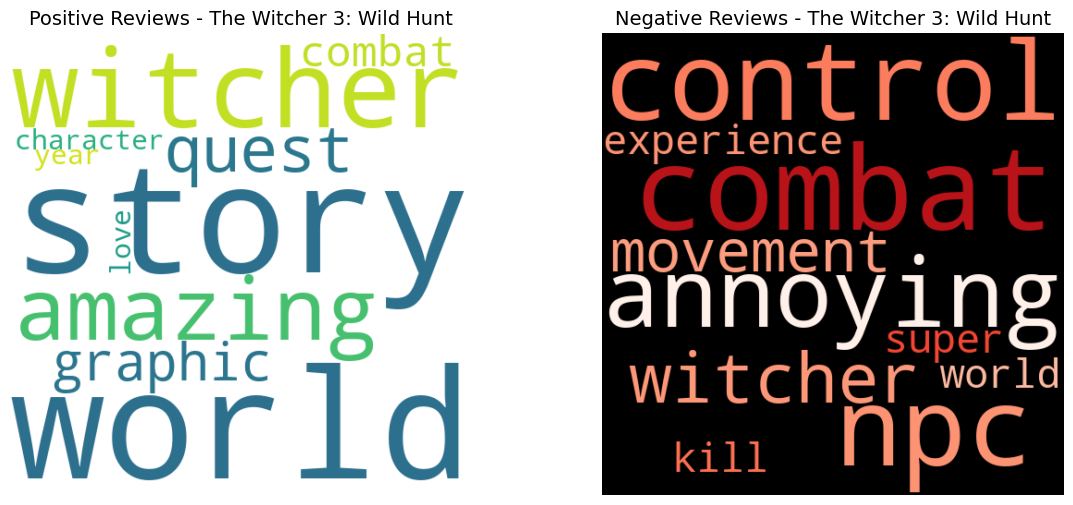

In [15]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Select a game for visualization
selected_game = "The Witcher 3: Wild Hunt"  # Change this to any game you want

# Extract positive and negative words for the selected game
game_data = df_top_words[df_top_words["Game"] == selected_game]

if not game_data.empty:
    pos_words = game_data["Top_Positive_Words"].values[0]
    neg_words = game_data["Top_Negative_Words"].values[0]

    # Convert lists to space-separated strings
    pos_text = " ".join(pos_words)
    neg_text = " ".join(neg_words)

    # Create figure for side-by-side word clouds
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Generate Positive Word Cloud
    wordcloud_pos = WordCloud(width=500, height=500, background_color="white").generate(pos_text)
    axes[0].imshow(wordcloud_pos, interpolation="bilinear")
    axes[0].axis("off")
    axes[0].set_title(f"Positive Reviews - {selected_game}", fontsize=14)

    # Generate Negative Word Cloud
    wordcloud_neg = WordCloud(width=500, height=500, background_color="black", colormap="Reds").generate(neg_text)
    axes[1].imshow(wordcloud_neg, interpolation="bilinear")
    axes[1].axis("off")
    axes[1].set_title(f"Negative Reviews - {selected_game}", fontsize=14)

    # Show the word clouds
    plt.show()
else:
    print(f"No data found for {selected_game}")


In [16]:
# Creating a DataFrame with extended user reviews
user_reviews = pd.DataFrame({
    "Game": [
        "The Witcher 3: Wild Hunt", 
        "Dark Souls 3", 
        "X-Morph: Defense", 
        "Cyberpunk 2077", 
        "Horizon Zero Dawn",
        "Assassin’s Creed Valhalla"
    ],
    "review": [
        "I really enjoyed The Witcher 3 because of its vast open world, deep story, and breathtaking graphics. The game offers an immersive experience with well-developed characters and rich lore. The combat mechanics feel smooth, and there are countless side quests that add depth to the world. However, it required a very strong PC, and I experienced frequent crashes, which sometimes ruined the immersion.",
        
        "Dark Souls 3 was an amazing experience. The quest design is intricate, and the story, though subtle, is deeply engaging for those who invest time in understanding the lore. The combat is extremely challenging but rewarding, requiring precision and strategy. The boss fights are intense and satisfying, though some of them felt repetitive. Additionally, certain difficulty spikes felt unbalanced, making progression frustrating at times.",
        
        "I did not like X-Morph: Defense because it's a tower defense game, and I’m not into that genre. The game lacks a compelling story, and the graphics felt outdated compared to modern strategy games. The gameplay quickly became repetitive, and there wasn't much variety in the mechanics. It didn’t hold my interest for long, and I found myself getting bored after a few levels.",
        
        "Cyberpunk 2077 had a lot of potential with its futuristic open world and deep RPG mechanics. The city felt alive with plenty of characters and side quests. However, the game was plagued with technical issues, including game-breaking bugs, crashes, and unoptimized performance. While the main story was engaging, the overall experience was disappointing due to the lack of polish at launch.",
        
        "Horizon Zero Dawn was an incredible game with a unique blend of open-world exploration, a strong protagonist, and a compelling sci-fi story. The combat felt dynamic, and the world was beautifully crafted with breathtaking landscapes. The enemy AI was intelligent, and each fight required strategy. The only downside was that some side missions felt repetitive after a while, but overall, it was an amazing experience.",
        
        "Assassin’s Creed Valhalla was an enjoyable game for the most part. The Viking setting was immersive, and the world was rich with details. The combat felt weighty, and there were plenty of things to do. However, I found the progression system to be too grindy, and the game felt repetitive after some time. The story, while engaging at first, started to lose its impact halfway through. The overall experience was decent but not exceptional."
    ],
    "recommended": [
        "True", 
        "True", 
        "False", 
        "False", 
        "True", 
        "False"
    ]
})

# Display the DataFrame
print(user_reviews)


                        Game  \
0   The Witcher 3: Wild Hunt   
1               Dark Souls 3   
2           X-Morph: Defense   
3             Cyberpunk 2077   
4          Horizon Zero Dawn   
5  Assassin’s Creed Valhalla   

                                              review recommended  
0  I really enjoyed The Witcher 3 because of its ...        True  
1  Dark Souls 3 was an amazing experience. The qu...        True  
2  I did not like X-Morph: Defense because it's a...       False  
3  Cyberpunk 2077 had a lot of potential with its...       False  
4  Horizon Zero Dawn was an incredible game with ...        True  
5  Assassin’s Creed Valhalla was an enjoyable gam...       False  


In [17]:
import os
import re
import csv
import sys
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer
from nltk.corpus import stopwords
import spacy
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from tqdm import tqdm

from scipy.stats import pearsonr

# Function to download NLTK resources
def download_nltk_resources():
    required_resources = ['wordnet', 'stopwords', 'punkt']
    for resource in required_resources:
        try:
            nltk.data.find(f'tokenizers/{resource}' if resource == 'punkt' else f'corpora/{resource}')
        except LookupError:
            nltk.download(resource)

download_nltk_resources()

# Function to install and load spaCy model
def install_spacy_model(model_name):
    try:
        return spacy.load(model_name)
    except OSError:
        print(f"Downloading spaCy model: {model_name}")
        subprocess.check_call([sys.executable, "-m", "spacy", "download", model_name])
        return spacy.load(model_name)

sp = install_spacy_model('en_core_web_sm')

# Enable tqdm for pandas
tqdm.pandas()

# Initialize stemmers and lemmatizer
porter = SnowballStemmer("english")
lmtzr = WordNetLemmatizer()
STOP_WORDS = set(stopwords.words('english'))


[nltk_data] Downloading package wordnet to /home/oliver/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/home/oliver/miniconda3/envs/Textmining_2/lib/python3.12/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.8.0) was trained with spaCy v3.8.0 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [18]:
"""
This module provides helper functions for text preprocessing. 
Each function applies punctuation removal and stopword removal, and then one of three options:
    0: Lowercasing only.
    1: Lowercasing plus stemming.
    2: Lemmatizing (using spaCy; original casing is preserved).

The functions return a string of tokens separated by spaces.
"""


def preprocess_lower(text):
    """
    Preprocess text by:
       - Converting to lowercase.
       - Removing punctuation.
       - Tokenizing.
       - Removing stopwords.
    
    Returns:
        str: A string of filtered tokens separated by spaces.
    """
    text_lower = text.lower()
    text_no_punct = re.sub(r'[^\w\s]', '', text_lower)
    tokens = word_tokenize(text_no_punct)
    filtered_tokens = [token for token in tokens if token not in STOP_WORDS]
    return " ".join(filtered_tokens)

def preprocess_stem(text):
    """
    Preprocess text by performing all steps in preprocess_lower() and then applying stemming.
    
    Returns:
        str: A string of stemmed tokens separated by spaces.
    """
    tokens = preprocess_lower(text).split()
    ps = PorterStemmer()
    stemmed_tokens = [ps.stem(token) for token in tokens]
    return " ".join(stemmed_tokens)


# Function to remove emojis and special characters
def clean_text(text):
    text = re.sub(r'\[.*?\]', '', text)  # Remove HTML-like tags [b], [i], etc.
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Keeps letters, numbers, and spaces
    return text

# Updated preprocess_lemma function
def preprocess_lemma(text):
    """
    Preprocess text by:
       - Removing special characters, emojis, and HTML tags.
       - Lemmatizing the text using spaCy.
       - Keeping only alphabetic words (removes numbers & symbols).
    
    Returns:
        str: A string of lemmatized words separated by spaces.
    """
    # Load spaCy model
    nlp = spacy.load("en_core_web_sm")
    text = clean_text(text)  # Remove special characters
    doc = nlp(text)  # Process text with spaCy
    lemmatized_tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]  # Keep only words
    return " ".join(lemmatized_tokens)



def tokenize(text, mode=0):
    """
    General tokenize function. Always applies punctuation and stopword removal and then:
    
      mode = 0: Applies lowercasing.
      mode = 1: Applies lowercasing and stemming.
      mode = 2: Applies lemmatization (without lowercasing the original text).
    
    Args:
        text (str): The input text to be processed.
        mode (int): Processing mode (0 for lowercasing; 1 for stemming; 2 for lemmatizing).

    Returns:
        str: A string of processed tokens separated by spaces.

    Raises:
        ValueError: If an invalid mode is provided.
    """
    if mode == 0:
        return preprocess_lower(text)
    elif mode == 1:
        return preprocess_stem(text)
    elif mode == 2:
        return preprocess_lemma(text)
    else:
        raise ValueError("Invalid mode. Please use 0 for lowercasing, 1 for stemming, or 2 for lemmatizing.")

In [19]:
#Getting the clean text column
mod=2 #Lemmatizing

# Pre-process the text column with progress tracking
try:
    user_reviews["cleaned_review"] = user_reviews["review"].progress_apply(lambda x: tokenize(str(x), mod))
    print("Done processing text.")
except Exception as e:
    print(f"Error processing text column: {e}")
    sys.exit(1)


  0%|          | 0/6 [00:00<?, ?it/s]/home/oliver/miniconda3/envs/Textmining_2/lib/python3.12/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.8.0) was trained with spaCy v3.8.0 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
100%|██████████| 6/6 [00:02<00:00,  2.27it/s]

Done processing text.


In [20]:
pos_reviews_cleaned = user_reviews[user_reviews["recommended"] == "True"].copy()
neg_reviews_cleaned = user_reviews[user_reviews["recommended"] == "False"].copy()
pos_reviews_cleaned = pos_reviews_cleaned.dropna(subset=['cleaned_review'])
pos_reviews_cleaned["cleaned_review"] = pos_reviews_cleaned["cleaned_review"].apply(remove_custom_stopwords)

# Remove NaN values and apply custom stopwords removal for negative reviews
neg_reviews_cleaned = neg_reviews_cleaned.dropna(subset=['cleaned_review'])
neg_reviews_cleaned["cleaned_review"] = neg_reviews_cleaned["cleaned_review"].apply(remove_custom_stopwords)

vectorizer_pos = TfidfVectorizer(stop_words="english", ngram_range=(1,2), max_features=5000)
vectorizer_neg = TfidfVectorizer(stop_words="english", ngram_range=(1,2), max_features=5000)

# Step 3: Apply TF-IDF on positive reviews
tfidf_matrix_pos = vectorizer_pos.fit_transform(pos_reviews_cleaned["cleaned_review"])
terms_pos = vectorizer_pos.get_feature_names_out()

# Step 4: Apply TF-IDF on negative reviews
tfidf_matrix_neg = vectorizer_neg.fit_transform(neg_reviews_cleaned["cleaned_review"])
terms_neg = vectorizer_neg.get_feature_names_out()

# Step 5: Compute Mean TF-IDF Scores
tfidf_sum_pos = tfidf_matrix_pos.mean(axis=0).A1
tfidf_sum_neg = tfidf_matrix_neg.mean(axis=0).A1

# Step 6: Create DataFrames with TF-IDF scores
tfidf_df_pos = pd.DataFrame({'term': terms_pos, 'tfidf_score': tfidf_sum_pos}).sort_values(by="tfidf_score", ascending=False)
tfidf_df_neg = pd.DataFrame({'term': terms_neg, 'tfidf_score': tfidf_sum_neg}).sort_values(by="tfidf_score", ascending=False)

# Step 7: Display the TF-IDF DataFrames
print("\nTop Positive User Profile TF-IDF Terms:\n", tfidf_df_pos.head(10))
print("\nTop Negative User Profile TF-IDF Terms:\n", tfidf_df_neg.head(10))


Top Positive User Profile TF-IDF Terms:
              term  tfidf_score
57     experience     0.103588
164         world     0.100936
120       require     0.077431
23         combat     0.077431
140         story     0.077431
14   breathtaking     0.067254
147        strong     0.067254
114         quest     0.066135
90           lore     0.066135
91    lore combat     0.066135

Top Negative User Profile TF-IDF Terms:
                    term  tfidf_score
28              defense     0.106637
112               story     0.087025
101          repetitive     0.078351
64                 lack     0.074260
73             mechanic     0.074260
82              overall     0.071511
39           experience     0.071511
88               plenty     0.071511
113        story engage     0.071511
83   overall experience     0.071511
